In [1]:
# Useful starting lines
%matplotlib inline
import datetime
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
from implementations import *

In [3]:
DATA_TRAIN_PATH = '../../data/train.csv' # TODO: download train data and supply path here 
y, x, ids = load_csv_data(DATA_TRAIN_PATH)

In [4]:
selector = np.all(x != -999.0, axis=1)
x_clean = x[selector]
y_clean = y[selector]

print(x.shape)
print(x_clean.shape)
    

(250000, 30)
(68114, 30)


Too many data lost in tX_clean, maybe we can make calculation without taking into account the -999.0 in the average
We can replace this value by NaN wich will be not taking into account during the standardization

In [227]:
def get_ind_percentiles(tX, tX_clean, i, percentile):
    arguments = []
    a = np.percentile(tX_clean[:,i],percentile)
    tX_perc = tX.copy()
    arguments = np.argwhere(tX_perc[tX[:,i] > round(a, 2)])
    return list(set(arguments[:,0]))

def remove_rows_by_percentiles(tX,tX_clean):
    args = []
    for i in range(tX.shape[1]):
        args= args+get_ind_percentiles(tX,tX_clean,i,99.97)
    flat_list = [item for item in args]
    mylist = list(set(flat_list))
    return mylist

In [230]:
arg = remove_rows_by_percentiles(x,x_clean)
x_perc = np.delete(x, arg, axis=0)
y_perc = np.delete(y, arg, axis=0)

In [232]:
y_perc.shape

(234948,)

In [217]:
selected_columns0 = [1, 2, 3, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 29]
selected_columns1 = [1, 2, 3, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 29]
selected_columns_ideal = [0, 1, 2, 3, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 29]

def selected_non_nan_columns(x):
    x_selected = np.zeros((len(x), len(selected_columns0)))
    for i in range(len(x)):
        s = np.take(x[i], indices=selected_columns0, axis=0)
        x_selected[i] = s
    return x_selected

In [233]:
x_sel = selected_non_nan_columns(x_perc)
x_sel.shape

(234948, 19)

In [234]:
v = x_sel != -999
v.all()

True

In [136]:
def standardize_NAN(tX):
    x_nan = x_sel.copy()
    for i in range(x_nan.shape[0]):
        for j in range(x_nan.shape[1]):
            if (x_nan[i,j] == -999.0):
                x_nan[i,j] = np.nan
    return (standardize(x_nan))

x_nan, mean_x_nan, std_x_nan = standardize_NAN(x)

# Tout les nans (correspondant a des valeurs non connues) sont remplacés par la moyenne de la colonnes
means_cols = np.nanmean(x_nan,axis=1)
for row in range(0,x_nan.shape[0]):
    for col in range(0,x_nan.shape[1]):
        if np.isnan(x_nan[row,col]):
            x_nan[row,col]=means_cols[col]

76.84007962749212


In [235]:
x_clean = x_sel
y_clean = y_perc

In [236]:
x_clean.shape

(234948, 19)

# 1.Least squares gradient descent

# Least square SDG

We can alter the gamma and the batch size

### Ridge regression

Best lambda is: 0.004520353656360241


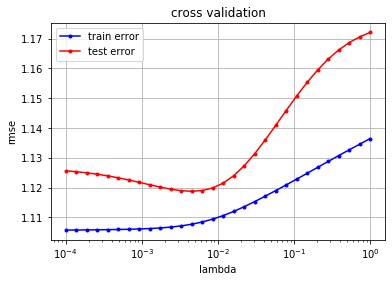

In [8]:
# Investigate the rmse loss with ridge regression for a given degree and different lambdas
# Print the best lambda, according to the rmse loss of the testing set (using cross-validation)
ridge_regression_invest(4, y_clean, x_clean)

In [10]:
# Compute the rmse loss with ridge regression for a given degree and lambda
degree_opt = 4
lambda_opt = 0.004520353656360241
x_poly = build_poly(x_clean, degree_opt)
w_rr_opt, loss_tr = ridge_regression(y_clean, x_poly, lambda_opt)
print("Training set mse: {}".format(loss_tr))

Training set mse: 0.6140426020023154


In [251]:
y_predicted = predict_labels(w_rr_opt, x_poly)
accuracy = []
accuracy.append((list(y_clean == y_predicted).count(True))/len(y_clean))
print("accuracy = {val}".format(val=accuracy))

accuracy = [0.7659950286871988]


### Outputing ze rezult

In [92]:
# testing rr with the test samples
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
y_te, x_te, ids_te = load_csv_data(DATA_TEST_PATH)

In [114]:
x_te_s = selected_non_nan_columns(x_te)
x_te_s.shape

(568238, 19)

In [115]:
OUTPUT_PATH = './lsq_19col_2' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(w_rr_opt, build_poly(x_te_s, degree_opt))
create_csv_submission(ids_te, y_pred, OUTPUT_PATH)